## Mid Project: Anomaly Detection with Autoencoders

Dr. Leslie Kerby, CS 6699 Advanced AI Methods <br>
Spring 2024

The goal of this assignment is to design, implement, and evaluate an autoencoder for the purpose of anomaly detection on the [Credit Card Fraud Detection dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud), available in Kaggle. This dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Note:
- Experiment with different autoencoder architectures, including varying the number and size of layers, to find the best model for this task.
- Discuss the importance of choosing an appropriate threshold for anomaly detection and the trade-off between false positives and false negatives.

# Part 1: Data Exploration and Preprocessing:
   - Familiarize yourself with the dataset. Understand the features and the target variable.
   - Handle missing values if any, and normalize the data if required. Given the PCA-transformed nature of the dataset, normalization might already be taken care of, but it's good to check.
   - Since the dataset is imbalanced, discuss how this might affect training and how you plan to address it.


In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
# This command sets the permissions of the file to be read and write only for the user
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Downloading the Credit Card Fraud Detection dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:00<00:00, 105MB/s]
100% 66.0M/66.0M [00:00<00:00, 101MB/s]


In [6]:
import zipfile
import os

# Extract the zip file
with zipfile.ZipFile('creditcardfraud.zip', 'r') as zip_ref:
    zip_ref.extractall('creditcardfraud_dataset')

# List the files in the extracted directory
print(os.listdir('creditcardfraud_dataset'))

['creditcard.csv']


In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/creditcardfraud_dataset/creditcard.csv')

# Display the first few rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Dataset overview
print(df.info())

# Statistical summary
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Print any columns with missing values

Series([], dtype: int64)


In [10]:
#Normalizing 'Time' and 'Amount' features. PCA components (V1-V28) do not require normalization
from sklearn.preprocessing import StandardScaler

# Normalize 'Time' and 'Amount'
scaler = StandardScaler()
df['NormalizedAmount'] = scaler.fit_transform(df[['Amount']])
df['NormalizedTime'] = scaler.fit_transform(df[['Time']])

#calling fit_transform separately for 'Amount' and 'Time' ensures each
#feature is scaled independently based on its own statistics (mean and standard deviation).

# Drop the original 'Time' and 'Amount' columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Display the first few rows to check the normalization
print(df.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class  NormalizedAmount  Normalized

The significant class imbalance needs special consideration, as it can lead to biased models that favor the majority class.

Common classification metrics like accuracy are not suitable. This is because in imbalanced datasets accuracy can be misleadingly high when a model simply predicts the majority class. This doesn't reflect the model's effectiveness at identifying the rarer, but often more important, minority class cases, in this case fradulent transactions.

Treating the problem as anomaly detection rather than a simple classification task is itself a particular strategy. In this approach, the model learns the pattern of the normal (majority) class and identifies anomalies (minority class) based on deviations from this pattern. Autoencoders are particularly suited for this, as they learn to reconstruct normal instances and can signal anomalies when there's a high reconstruction error. Moreover, resampling techniques can be used by adjusting the dataset composition to mitigate imbalance, either by increasing the number of minority class instances (oversampling) or decreasing the majority class instances (undersampling). Techniques like SMOTE (Synthetic Minority Over-sampling Technique) generate synthetic samples rather than simply duplicating existing ones. Additionally, adjusting class weights during model training, and placing more emphasis on correctly predicting the minority class, can also be done.

In terms of evaluation metrics, AUPRC (Area Under the Precision-Recall Curve) can be utilized. Precision-recall curves are good for imbalanced datasets because they focus on the performance of the model on the minority class. On the other hand, confusion matrix accuracy is also not meaningful for unbalanced classification, as mentioned before. AUPRC is better as it summarizes the trade-off between precision (the ratio of true positive predictions to all positive predictions) and recall (the ratio of true positive predictions to all actual positives) across different thresholds. Additionally, precision, recall, F1-score can be taken into account to evaluate our models.

# Part 2: Model Design
   - Design an autoencoder architecture suitable for this dataset. Given the nature of the data (numerical and possibly high-dimensional), a dense (fully connected) network might be a good starting point.
   - Consider the size of the latent space carefully; it should be small enough to force the autoencoder to learn a compressed representation but large enough to capture the essential characteristics of normal transactions.

In [11]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

# Features and target variable
X = df.drop(['Class'], axis=1)
y = df['Class']

# Splitting the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, splitting the training + validation set into separate training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2
# i.e train-valid-test: 60-20-20 split

# Ensuring everything is converted to a numpy array to avoid issues with TensorFlow
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

In [12]:
import  numpy as np
# Checking the number of fraudulent transactions in each set
num_fraud_train = np.sum(y_train == 1)
num_fraud_valid = np.sum(y_valid == 1)
num_fraud_test = np.sum(y_test == 1)

print("Number of fraudulent transactions in the training set:", num_fraud_train)
print("Number of fraudulent transactions in the validation set:", num_fraud_valid)
print("Number of fraudulent transactions in the test set:", num_fraud_test)

Number of fraudulent transactions in the training set: 295
Number of fraudulent transactions in the validation set: 99
Number of fraudulent transactions in the test set: 98


In [13]:
X_train.shape

(170883, 30)

## Architecture - 1

In [14]:
import tensorflow as tf

# Define the size of the input
input_dim = X_train.shape[1] #X_train.shape[1] gives the number of columns i.e 30

# Encoder
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(input_dim,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu")  # Latent space representation (compressed representation of the input data.)
], name="encoder")

# Decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=(16,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(input_dim, activation="sigmoid")  # sigmoid Since the input data is normalized between 0 and 1
], name="decoder")

# Autoencoder
autoencoder = tf.keras.Sequential([encoder, decoder])

# Model summary
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 16)                4592      
                                                                 
 decoder (Sequential)        (None, 30)                4606      
                                                                 
Total params: 9198 (35.93 KB)
Trainable params: 9198 (35.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Architecture - 2. Also trying without Normalized Time feature

In [42]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,NormalizedAmount,NormalizedTime
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [43]:
df_notime=df.copy()

In [44]:
df_notime.drop(['NormalizedTime'], axis=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,NormalizedAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.350151
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.254117
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.081839
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.313249


In [45]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

# Features and target variable
X = df_notime.drop(['Class'], axis=1)
y = df_notime['Class']

# Splitting the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, splitting the training + validation set into separate training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2
# i.e train-valid-test: 60-20-20 split

# Ensuring everything is converted to a numpy array to avoid issues with TensorFlow
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

In [46]:
import  numpy as np
# Checking the number of fraudulent transactions in each set
num_fraud_train = np.sum(y_train == 1)
num_fraud_valid = np.sum(y_valid == 1)
num_fraud_test = np.sum(y_test == 1)

print("Number of fraudulent transactions in the training set:", num_fraud_train)
print("Number of fraudulent transactions in the validation set:", num_fraud_valid)
print("Number of fraudulent transactions in the test set:", num_fraud_test)

Number of fraudulent transactions in the training set: 295
Number of fraudulent transactions in the validation set: 99
Number of fraudulent transactions in the test set: 98


In [47]:
X_train.shape[1]

30

In [48]:
import tensorflow as tf

# Define the size of the input
input_dim = X_train.shape[1] #X_train.shape[1] gives the number of columns i.e 30

# Encoder
encoder_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(input_dim,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu")  # Latent space representation (compressed representation of the input data.)
], name="encoder_2")

# Decoder
decoder_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=(12,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(input_dim, activation="sigmoid")  # sigmoid Since the input data is normalized between 0 and 1
], name="decoder_2")

# Autoencoder
autoencoder_2 = tf.keras.Sequential([encoder_2, decoder_2])

# Model summary
autoencoder_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Sequential)      (None, 12)                4460      
                                                                 
 decoder_2 (Sequential)      (None, 30)                4478      
                                                                 
Total params: 8938 (34.91 KB)
Trainable params: 8938 (34.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Architecture 3: Denoising Autoencoder  using gaussian noise

In [ ]:
# Keeping normalized time as a feature

In [ ]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,NormalizedAmount,NormalizedTime
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [ ]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

# Features and target variable
X = df.drop(['Class'], axis=1)
y = df['Class']

# Splitting the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, splitting the training + validation set into separate training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2
# i.e train-valid-test: 60-20-20 split

# Ensuring everything is converted to a numpy array to avoid issues with TensorFlow
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

In [ ]:
from tensorflow.keras.layers import Dense, Input, GaussianNoise
from tensorflow.keras.models import Model

input_dim = X_train.shape[1]

# Input layer with the shape of the data
input_layer = Input(shape=(input_dim, ))

# Adding Gaussian noise
# The `stddev` parameter controls the standard deviation of the noise distribution
noise_layer = GaussianNoise(stddev=0.4)(input_layer)

# Encoder
encoded = Dense(128, activation='relu')(noise_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)  # Latent space representation

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Reconstruction of the input

# Autoencoder model
autoencoder_3 = Model(input_layer, decoded)

autoencoder_3.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30)]              0         
                                                                 
 gaussian_noise_11 (Gaussia  (None, 30)                0         
 nNoise)                                                         
                                                                 
 dense_84 (Dense)            (None, 128)               3968      
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 dense_86 (Dense)            (None, 32)                2080      
                                                                 
 dense_87 (Dense)            (None, 64)                2112      
                                                           

## Architecture 4: Denoising Autoencoder using dropout

In [69]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

# Features and target variable
X = df.drop(['Class'], axis=1)
y = df['Class']

# Splitting the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, splitting the training + validation set into separate training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2
# i.e train-valid-test: 60-20-20 split

# Ensuring everything is converted to a numpy array to avoid issues with TensorFlow
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

In [70]:
import  numpy as np
# Checking the number of fraudulent transactions in each set
num_fraud_train = np.sum(y_train == 1)
num_fraud_valid = np.sum(y_valid == 1)
num_fraud_test = np.sum(y_test == 1)

print("Number of fraudulent transactions in the training set:", num_fraud_train)
print("Number of fraudulent transactions in the validation set:", num_fraud_valid)
print("Number of fraudulent transactions in the test set:", num_fraud_test)

Number of fraudulent transactions in the training set: 295
Number of fraudulent transactions in the validation set: 99
Number of fraudulent transactions in the test set: 98


In [71]:
X_train.shape

(170883, 30)

In [76]:
import tensorflow as tf

# Define the size of the input
input_dim = X_train.shape[1] #X_train.shape[1] gives the number of columns i.e 30

# Encoder
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(130, activation="relu", input_shape=(input_dim,)),
    tf.keras.layers.Dropout(0.4),  # Dropout layer for regularization
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.3),  # Dropout layer for regularization
    tf.keras.layers.Dense(70, activation="relu"),
    tf.keras.layers.Dense(40, activation="relu")
], name="encoder")

# Decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(70, activation="relu", input_shape=(40,)),
    tf.keras.layers.Dropout(0.3),  # Dropout layer for regularization
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer for regularization
    tf.keras.layers.Dense(130, activation="relu"),
    tf.keras.layers.Dense(input_dim)
], name="decoder")

# Autoencoder
autoencoder_4 = tf.keras.Sequential([encoder, decoder])

# Model summary
autoencoder_4.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 40)                27040     
                                                                 
 decoder (Sequential)        (None, 30)                27030     
                                                                 
Total params: 54070 (211.21 KB)
Trainable params: 54070 (211.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Architecture 5: Adding more layers & Neurons to architecture 4

In [113]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

# Features and target variable
X = df.drop(['Class'], axis=1)
y = df['Class']

# Splitting the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, splitting the training + validation set into separate training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2
# i.e train-valid-test: 60-20-20 split

# Ensuring everything is converted to a numpy array to avoid issues with TensorFlow
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

In [114]:
import  numpy as np
# Checking the number of fraudulent transactions in each set
num_fraud_train = np.sum(y_train == 1)
num_fraud_valid = np.sum(y_valid == 1)
num_fraud_test = np.sum(y_test == 1)

print("Number of fraudulent transactions in the training set:", num_fraud_train)
print("Number of fraudulent transactions in the validation set:", num_fraud_valid)
print("Number of fraudulent transactions in the test set:", num_fraud_test)

Number of fraudulent transactions in the training set: 295
Number of fraudulent transactions in the validation set: 99
Number of fraudulent transactions in the test set: 98


In [115]:
X_train.shape

(170883, 30)

In [119]:
import tensorflow as tf

# Define the size of the input
input_dim = X_train.shape[1] #X_train.shape[1] gives the number of columns i.e 30

# Encoder
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(150, activation="relu", input_shape=(input_dim,)),
    tf.keras.layers.Dropout(0.4),  # Dropout layer for regularization
    tf.keras.layers.Dense(110, activation="relu"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer for regularization
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(40, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation="relu")
], name="encoder")

# Decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation="relu", input_shape=(20,)),
    tf.keras.layers.Dropout(0.3),  # Dropout layer for regularization
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer for regularization
    tf.keras.layers.Dense(110, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(130, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(input_dim)
], name="decoder")

# Autoencoder
autoencoder_5 = tf.keras.Sequential([encoder, decoder])

# Model summary
autoencoder_5.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                34200     
                                                                 
 decoder (Sequential)        (None, 30)                31390     
                                                                 
Total params: 65590 (256.21 KB)
Trainable params: 65590 (256.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Part 3: Training
   - Train your autoencoder using only the normal transactions in the training set. This is crucial as the autoencoder needs to learn to reconstruct normal transaction profiles.
   - Validate the performance of your autoencoder on a separate set of normal transactions to tune hyperparameters and avoid overfitting.

## Architecture - 1

In [15]:
# Filter out normal transactions for training
X_train_normal = X_train[y_train == 0]

# Similarly, for validation, to evaluate model performance
X_valid_normal = X_valid[y_valid == 0]

print(X_train_normal.shape)
print(X_valid_normal.shape)

(170588, 30)
(56863, 30)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error') #mse measures the difference between the original inputs and their reconstructions

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=200,
    batch_size=256,
    validation_data=(X_valid_normal, X_valid_normal),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/200
667/667 [==============================] - 6s 4ms/step - loss: 0.8889 - val_loss: 0.8392
Epoch 2/200
667/667 [==============================] - 5s 7ms/step - loss: 0.7870 - val_loss: 0.8087
Epoch 3/200
667/667 [==============================] - 4s 6ms/step - loss: 0.7684 - val_loss: 0.7977
Epoch 4/200
667/667 [==============================] - 4s 6ms/step - loss: 0.7597 - val_loss: 0.7898
Epoch 5/200
667/667 [==============================] - 4s 6ms/step - loss: 0.7527 - val_loss: 0.7841
Epoch 6/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7488 - val_loss: 0.7819
Epoch 7/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7464 - val_loss: 0.7792
Epoch 8/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7447 - val_loss: 0.7779
Epoch 9/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7438 - val_loss: 0.7773
Epoch 10/200
667/667 [==============================] - 4s 6ms/step - loss: 0.7430 - val_lo

In [17]:
# Evaluate the model on the validation set
val_loss = autoencoder.evaluate(X_valid_normal, X_valid_normal)
print("Validation Loss:", val_loss)

1777/1777 [==============================] - 4s 3ms/step - loss: 0.7689
Validation Loss: 0.7689158320426941


## Architecture - 2.

In [49]:
# Filter out normal transactions for training
X_train_normal = X_train[y_train == 0]

# Similarly, for validation, to evaluate model performance
X_valid_normal = X_valid[y_valid == 0]

print(X_train_normal.shape)
print(X_valid_normal.shape)

(170588, 30)
(56863, 30)


In [50]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error') #mse measures the difference between the original inputs and their reconstructions

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=200,
    batch_size=256,
    validation_data=(X_valid_normal, X_valid_normal),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/200
667/667 [==============================] - 6s 6ms/step - loss: 0.7351 - val_loss: 0.7691
Epoch 2/200
667/667 [==============================] - 3s 5ms/step - loss: 0.7351 - val_loss: 0.7687
Epoch 3/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7349 - val_loss: 0.7687
Epoch 4/200
667/667 [==============================] - 3s 5ms/step - loss: 0.7349 - val_loss: 0.7692
Epoch 5/200
667/667 [==============================] - 4s 6ms/step - loss: 0.7349 - val_loss: 0.7687
Epoch 6/200
667/667 [==============================] - 3s 5ms/step - loss: 0.7348 - val_loss: 0.7689
Epoch 7/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7348 - val_loss: 0.7686
Epoch 8/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7347 - val_loss: 0.7686
Epoch 9/200
667/667 [==============================] - 4s 6ms/step - loss: 0.7348 - val_loss: 0.7687
Epoch 10/200
667/667 [==============================] - 3s 5ms/step - loss: 0.7347 - val_lo

In [51]:
# Evaluate the model on the validation set
val_loss = autoencoder.evaluate(X_valid_normal, X_valid_normal)
print("Validation Loss:", val_loss)

1777/1777 [==============================] - 4s 2ms/step - loss: 0.7679
Validation Loss: 0.767927348613739


In [52]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
autoencoder_2.compile(optimizer='adam', loss='mean_squared_error') #mse measures the difference between the original inputs and their reconstructions

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = autoencoder_2.fit(
    X_train_normal, X_train_normal,
    epochs=200,
    batch_size=256,
    validation_data=(X_valid_normal, X_valid_normal),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/200
667/667 [==============================] - 5s 4ms/step - loss: 0.8960 - val_loss: 0.8638
Epoch 2/200
667/667 [==============================] - 3s 4ms/step - loss: 0.8078 - val_loss: 0.8247
Epoch 3/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7862 - val_loss: 0.8170
Epoch 4/200
667/667 [==============================] - 4s 6ms/step - loss: 0.7783 - val_loss: 0.8097
Epoch 5/200
667/667 [==============================] - 3s 5ms/step - loss: 0.7740 - val_loss: 0.8085
Epoch 6/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7706 - val_loss: 0.8026
Epoch 7/200
667/667 [==============================] - 3s 5ms/step - loss: 0.7674 - val_loss: 0.8013
Epoch 8/200
667/667 [==============================] - 4s 6ms/step - loss: 0.7661 - val_loss: 0.8008
Epoch 9/200
667/667 [==============================] - 3s 4ms/step - loss: 0.7653 - val_loss: 0.7994
Epoch 10/200
667/667 [==============================] - 3s 5ms/step - loss: 0.7644 - val_lo

In [53]:
# Evaluate the model on the validation set
val_loss = autoencoder_2.evaluate(X_valid_normal, X_valid_normal)
print("Validation Loss:", val_loss)

1777/1777 [==============================] - 4s 2ms/step - loss: 0.7620
Validation Loss: 0.7620068788528442


It seems, removing the time feature is not making much (if any) difference

## Architecture 3

In [ ]:
# Filter out normal transactions for training
X_train_normal = X_train[y_train == 0]

# Similarly, for validation, to evaluate model performance
X_valid_normal = X_valid[y_valid == 0]

print(X_train_normal.shape)
print(X_valid_normal.shape)

(170588, 30)
(56863, 30)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
autoencoder_3.compile(optimizer='adam', loss='mean_squared_error') #mse measures the difference between the original inputs and their reconstructions

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = autoencoder_3.fit(
    X_train_normal, X_train_normal,
    epochs=200,
    batch_size=128,
    validation_data=(X_valid_normal, X_valid_normal),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/200
1333/1333 [==============================] - 8s 5ms/step - loss: 0.8250 - val_loss: 0.8134
Epoch 2/200
1333/1333 [==============================] - 6s 4ms/step - loss: 0.7820 - val_loss: 0.7964
Epoch 3/200
1333/1333 [==============================] - 7s 5ms/step - loss: 0.7720 - val_loss: 0.7920
Epoch 4/200
1333/1333 [==============================] - 6s 4ms/step - loss: 0.7688 - val_loss: 0.7876
Epoch 5/200
1333/1333 [==============================] - 6s 5ms/step - loss: 0.7651 - val_loss: 0.7864
Epoch 6/200
1333/1333 [==============================] - 5s 4ms/step - loss: 0.7633 - val_loss: 0.7869
Epoch 7/200
1333/1333 [==============================] - 6s 5ms/step - loss: 0.7624 - val_loss: 0.7866
Epoch 8/200
1333/1333 [==============================] - 6s 4ms/step - loss: 0.7618 - val_loss: 0.7846
Epoch 9/200
1333/1333 [==============================] - 6s 5ms/step - loss: 0.7601 - val_loss: 0.7825
Epoch 10/200
1333/1333 [==============================] - 6s 4ms/step - l

In [ ]:
# Evaluate the model on the validation set
val_loss = autoencoder_3.evaluate(X_valid_normal, X_valid_normal)
print("Validation Loss:", val_loss)

1777/1777 [==============================] - 4s 2ms/step - loss: 0.7664
Validation Loss: 0.7664169073104858


## Architecture 4: Denoising with dropout

In [77]:
# Filter out normal transactions for training
X_train_normal = X_train[y_train == 0]

# Similarly, for validation, to evaluate model performance
X_valid_normal = X_valid[y_valid == 0]

print(X_train_normal.shape)
print(X_valid_normal.shape)

(170588, 30)
(56863, 30)


In [78]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
autoencoder_4.compile(optimizer='adam', loss='mean_squared_error') #mse measures the difference between the original inputs and their reconstructions

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder_4.fit(
    X_train_normal, X_train_normal,
    epochs=200,
    batch_size=128,
    validation_data=(X_valid_normal, X_valid_normal),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/200
1333/1333 [==============================] - 14s 5ms/step - loss: 0.5996 - val_loss: 0.4001
Epoch 2/200
1333/1333 [==============================] - 7s 6ms/step - loss: 0.4629 - val_loss: 0.3349
Epoch 3/200
1333/1333 [==============================] - 7s 6ms/step - loss: 0.4283 - val_loss: 0.3090
Epoch 4/200
1333/1333 [==============================] - 7s 5ms/step - loss: 0.4089 - val_loss: 0.3038
Epoch 5/200
1333/1333 [==============================] - 8s 6ms/step - loss: 0.3920 - val_loss: 0.2983
Epoch 6/200
1333/1333 [==============================] - 7s 5ms/step - loss: 0.3778 - val_loss: 0.3036
Epoch 7/200
1333/1333 [==============================] - 7s 6ms/step - loss: 0.3721 - val_loss: 0.2699
Epoch 8/200
1333/1333 [==============================] - 7s 5ms/step - loss: 0.3651 - val_loss: 0.2696
Epoch 9/200
1333/1333 [==============================] - 7s 6ms/step - loss: 0.3597 - val_loss: 0.3012
Epoch 10/200
1333/1333 [==============================] - 6s 5ms/step - 

In [79]:
# Evaluate the model on the validation set
val_loss = autoencoder_4.evaluate(X_valid_normal, X_valid_normal)
print("Validation Loss:", val_loss)

1777/1777 [==============================] - 5s 3ms/step - loss: 0.1973
Validation Loss: 0.19728758931159973


## Architecture 5:

In [120]:
# Filter out normal transactions for training
X_train_normal = X_train[y_train == 0]

# Similarly, for validation, to evaluate model performance
X_valid_normal = X_valid[y_valid == 0]

print(X_train_normal.shape)
print(X_valid_normal.shape)

(170588, 30)
(56863, 30)


In [121]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
autoencoder_5.compile(optimizer='adam', loss='mean_squared_error') #mse measures the difference between the original inputs and their reconstructions

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder_5.fit(
    X_train_normal, X_train_normal,
    epochs=200,
    batch_size=128,
    validation_data=(X_valid_normal, X_valid_normal),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/200
1333/1333 [==============================] - 23s 14ms/step - loss: 0.9034 - val_loss: 0.8999
Epoch 2/200
1333/1333 [==============================] - 8s 6ms/step - loss: 0.8128 - val_loss: 0.7948
Epoch 3/200
1333/1333 [==============================] - 10s 8ms/step - loss: 0.7761 - val_loss: 0.8359
Epoch 4/200
1333/1333 [==============================] - 11s 8ms/step - loss: 0.7656 - val_loss: 0.7813
Epoch 5/200
1333/1333 [==============================] - 9s 7ms/step - loss: 0.7466 - val_loss: 0.7573
Epoch 6/200
1333/1333 [==============================] - 8s 6ms/step - loss: 0.7378 - val_loss: 0.7701
Epoch 7/200
1333/1333 [==============================] - 17s 13ms/step - loss: 0.7438 - val_loss: 0.7269
Epoch 8/200
1333/1333 [==============================] - 10s 7ms/step - loss: 0.7160 - val_loss: 0.7149
Epoch 9/200
1333/1333 [==============================] - 12s 9ms/step - loss: 0.7074 - val_loss: 0.6952
Epoch 10/200
1333/1333 [==============================] - 13s 10m

In [122]:
# Evaluate the model on the validation set
val_loss = autoencoder_5.evaluate(X_valid_normal, X_valid_normal)
print("Validation Loss:", val_loss)

1777/1777 [==============================] - 6s 4ms/step - loss: 0.6514
Validation Loss: 0.6513909101486206


# Part 4: Anomaly Detection
   - Use the reconstruction error as the metric to detect anomalies. Transactions that result in a high reconstruction error are likely to be anomalies (fraudulent transactions in this case).
   - Determine a threshold for the reconstruction error above which a transaction is considered fraudulent. This can be based on a validation set or statistical methods.

## Architecture 1

### Architecture - 1: Hyperparameter/Threshold 1

In [18]:
# Reconstruct the validation data (normal and fraudulent combined)
X_valid_reconstructed = autoencoder.predict(X_valid)

# Calculate the mean squared error (reconstruction error) for each transaction
reconstruction_errors = np.mean(np.power(X_valid - X_valid_reconstructed, 2), axis=1)
#axis=1, the function computes the mean across each row (i.e., across all features of a single transaction)
#resulting in a single error value for each transaction.a
# It quantifies, on average, how much the model's reconstruction of a transaction
# deviates from the original transaction data.

1781/1781 [==============================] - 3s 2ms/step


In [19]:
reconstruction_errors.shape

(56962,)

In [20]:
reconstruction_errors[:10]

array([0.7301966 , 0.55172737, 0.13172207, 0.89541953, 0.18033419,
       0.56412026, 0.55143155, 0.68174873, 0.1477919 , 0.43831644])

In [21]:
print(max(reconstruction_errors))
print(min(reconstruction_errors))

1794.6765678750837
0.04349671255036144


In [22]:
X_valid.shape

(56962, 30)

In [23]:
# Using statistical method:
# Setting a threshold as be the mean error plus three standard deviations.
threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)

In [24]:
threshold

25.697141662011905

In [25]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [26]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 122
Number of normal transactions detected: 56840


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.15      0.18      0.16        99

    accuracy                           1.00     56962
   macro avg       0.57      0.59      0.58     56962
weighted avg       1.00      1.00      1.00     56962

[[56759   104]
 [   81    18]]


In [28]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# The reconstruction errors can serve as the anomaly scores (higher error = more anomalous)
anomaly_scores = reconstruction_errors

# Calculate AUC
roc_auc = roc_auc_score(y_valid, anomaly_scores)
print(f"AUC: {roc_auc}") # provides an overall measure of model performance,

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid, anomaly_scores)
# Calculate AUPRC
auprc = auc(recall, precision)
print(f"AUPRC: {auprc}") #gives an indication of how well the model identifies the positive (fraudulent) class.


AUC: 0.9381236525073466
AUPRC: 0.11325694074401803


In [ ]:
'''
Classification Report:
Class 0 (Normal Transactions):
Precision: 1.00: every transaction the model labeled as normal was indeed normal.
Recall: 1.00: model successfully identified all normal transactions.
F1-Score: 1.00: i.e perfect performance for the normal class.
Support: 56,863 transactions were actually normal, providing the total number of true cases in the data for this class.

Class 1 (Fraudulent Transactions):
Precision: 0.15: only 15% of the transactions the model labeled as fraudulent were actually fraudulent.
Recall: 0.18: the model identified 18% of all the actual fraudulent transactions.
F1-Score: 0.17 reflects the balance between precision and recall for the fraudulent class; this is quite low, suggesting the model is not performing well on the fraudulent class.
Support: 99 transactions were actually fraudulent'''
'''
Confusion Matrix:
Top-left (True Negatives): 56,763 normal transactions were correctly identified as normal.
Top-right (False Positives): 100 normal transactions were incorrectly identified as fraudulent.
Bottom-left (False Negatives): 81 fraudulent transactions were incorrectly identified as normal.
Bottom-right (True Positives): 18 fraudulent transactions were correctly identified as fraudulent.
'''
'''
The low AUPRC indicates that although the model can distinguish between classes,
it may not be as effective when it comes to correctly identifying
all the positive instances (in this case, fraudulent transactions).
'''

'\nThe low AUPRC indicates that although the model can distinguish between classes,\nit may not be as effective when it comes to correctly identifying\nall the positive instances (in this case, fraudulent transactions).\n'

Therefore, this set of hyyperparameters is not working very well and should be changed.

### Architecture - 1: Hyperparameter/Threshold 2

In [29]:
# Changing the threshold
# Using statistical method:
# Setting a threshold as be the mean error plus 1 standard deviations.
threshold = np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors)
print(threshold)

17.39910939190181


In [30]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [31]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 196
Number of normal transactions detected: 56766


In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.15      0.29      0.20        99

    accuracy                           1.00     56962
   macro avg       0.57      0.64      0.60     56962
weighted avg       1.00      1.00      1.00     56962

[[56696   167]
 [   70    29]]


### Architecture - 1: Hyperparameter/Threshold 3

In [33]:
# Changing the threshold
# Using statistical method:
# Setting a threshold as be the mean error plus 1 standard deviations.
threshold = np.mean(reconstruction_errors) + 1*np.std(reconstruction_errors)
print(threshold)

9.101077121791715


In [34]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [35]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 483
Number of normal transactions detected: 56479


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.10      0.48      0.16        99

    accuracy                           0.99     56962
   macro avg       0.55      0.74      0.58     56962
weighted avg       1.00      0.99      0.99     56962

[[56428   435]
 [   51    48]]


Threshold of 17.39910939190181, seems to work the best amongst the ones I tried.

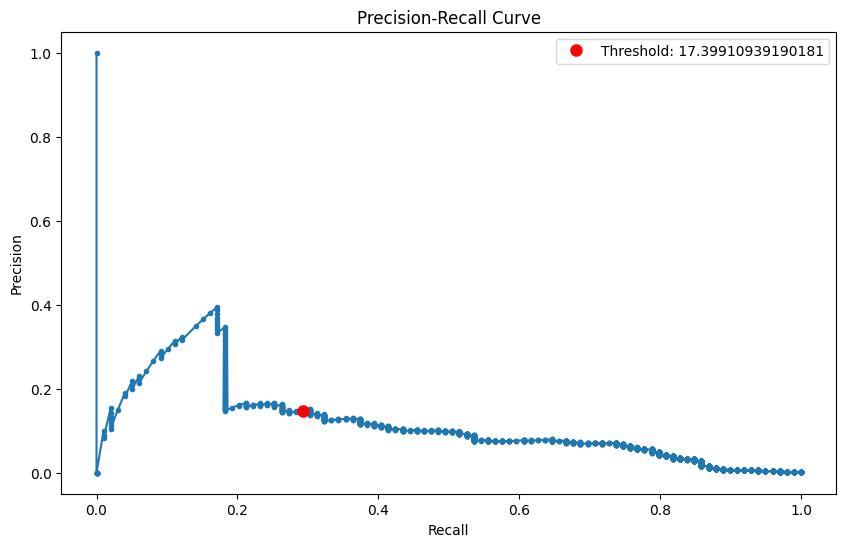

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

chosen_threshold = 17.39910939190181

# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_valid, anomaly_scores)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Adding a threshold line
threshold_label_idx = np.argmin(np.abs(thresholds - chosen_threshold))  # Closest index to the chosen threshold
plt.plot(recall[threshold_label_idx], precision[threshold_label_idx], 'ro', markersize=8, label=f'Threshold: {chosen_threshold}')
plt.legend()

plt.show()


In [38]:
y_valid == 0

215004    True
260590    True
123179    True
40328     True
16509     True
          ... 
122716    True
126872    True
6426      True
274365    True
281740    True
Name: Class, Length: 56962, dtype: bool

In [39]:
y_valid == 1

215004    False
260590    False
123179    False
40328     False
16509     False
          ...  
122716    False
126872    False
6426      False
274365    False
281740    False
Name: Class, Length: 56962, dtype: bool

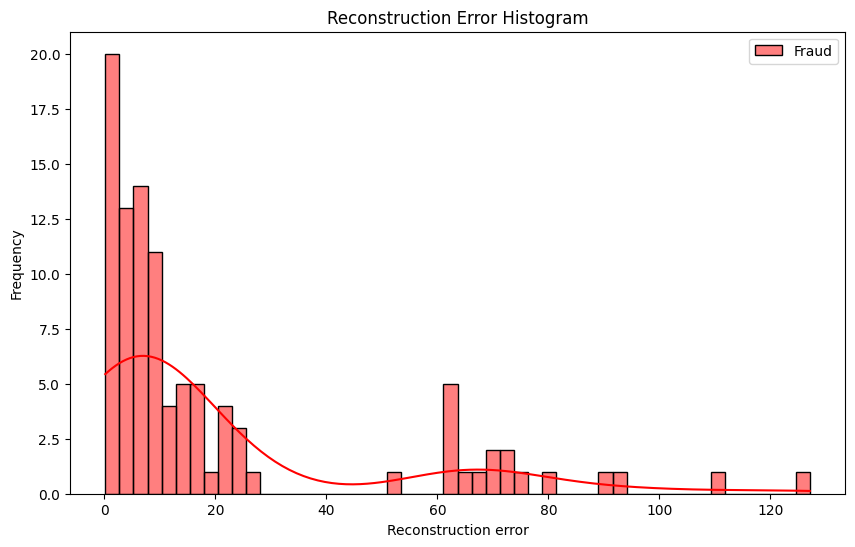

In [40]:
import seaborn as sns

# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
#sns.histplot(errors_normal, bins=50, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
#plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()


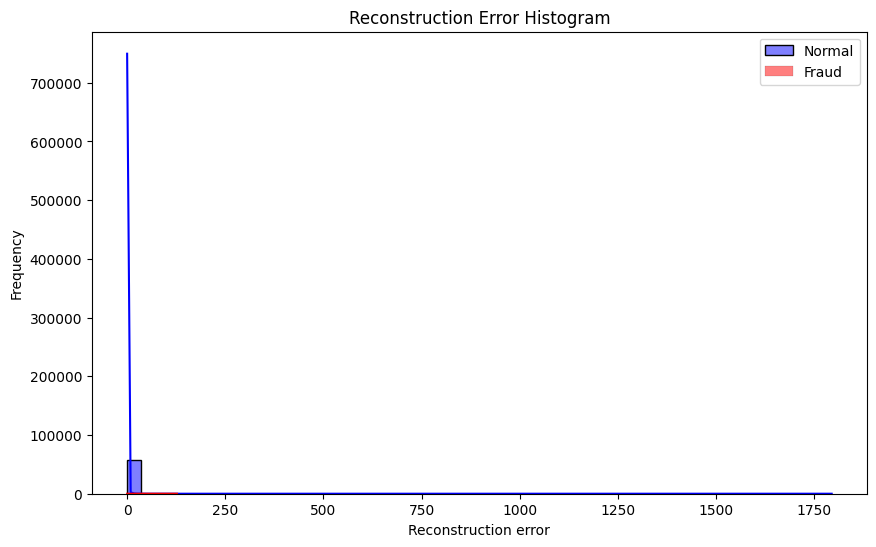

In [41]:
import seaborn as sns

# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=50, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
#plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()

## Architecture 2

In [54]:
# Reconstruct the validation data (normal and fraudulent combined)
X_valid_reconstructed = autoencoder_2.predict(X_valid)

# Calculate the mean squared error (reconstruction error) for each transaction
reconstruction_errors = np.mean(np.power(X_valid - X_valid_reconstructed, 2), axis=1)
#axis=1, the function computes the mean across each row (i.e., across all features of a single transaction)
#resulting in a single error value for each transaction.a
# It quantifies, on average, how much the model's reconstruction of a transaction
# deviates from the original transaction data.

1781/1781 [==============================] - 3s 2ms/step


In [55]:
reconstruction_errors.shape

(56962,)

In [56]:
reconstruction_errors[:10]

array([0.71547373, 0.58711622, 0.08946989, 0.90407362, 0.15539902,
       0.61270645, 0.55396375, 0.6872338 , 0.14693192, 0.45185011])

In [57]:
print(max(reconstruction_errors))
print(min(reconstruction_errors))

1793.667251331704
0.040726717828450915


In [58]:
X_valid.shape

(56962, 30)

In [59]:
# Using statistical method:
# Setting a threshold as be the mean error plus three standard deviations.
threshold = np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors)

In [60]:
threshold

17.36977293936394

In [61]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [62]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 194
Number of normal transactions detected: 56768


In [63]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.15      0.29      0.20        99

    accuracy                           1.00     56962
   macro avg       0.57      0.65      0.60     56962
weighted avg       1.00      1.00      1.00     56962

[[56698   165]
 [   70    29]]


In [64]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# The reconstruction errors can serve as the anomaly scores (higher error = more anomalous)
anomaly_scores = reconstruction_errors

# Calculate AUC
roc_auc = roc_auc_score(y_valid, anomaly_scores)
print(f"AUC: {roc_auc}") # provides an overall measure of model performance,

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid, anomaly_scores)
# Calculate AUPRC
auprc = auc(recall, precision)
print(f"AUPRC: {auprc}") #gives an indication of how well the model identifies the positive (fraudulent) class.


AUC: 0.9403613540750168
AUPRC: 0.11578812021415055


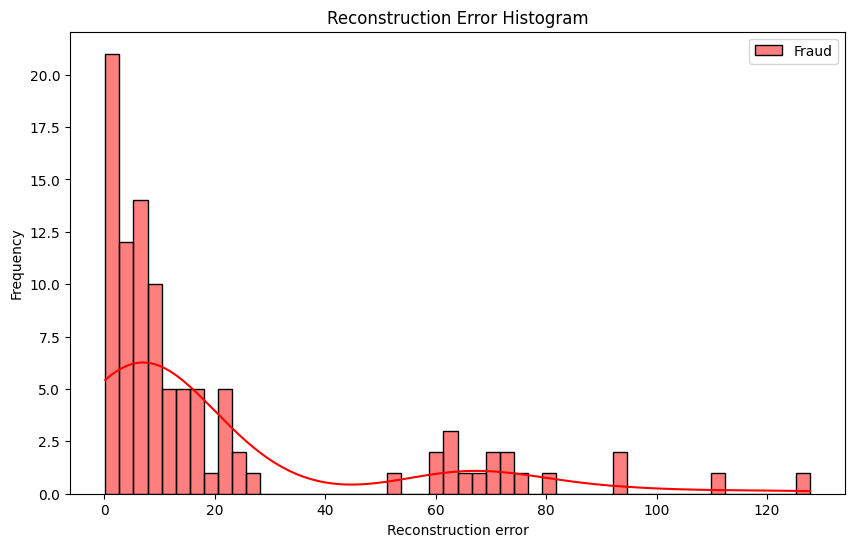

In [65]:
import seaborn as sns

# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
#sns.histplot(errors_normal, bins=50, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
#plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()


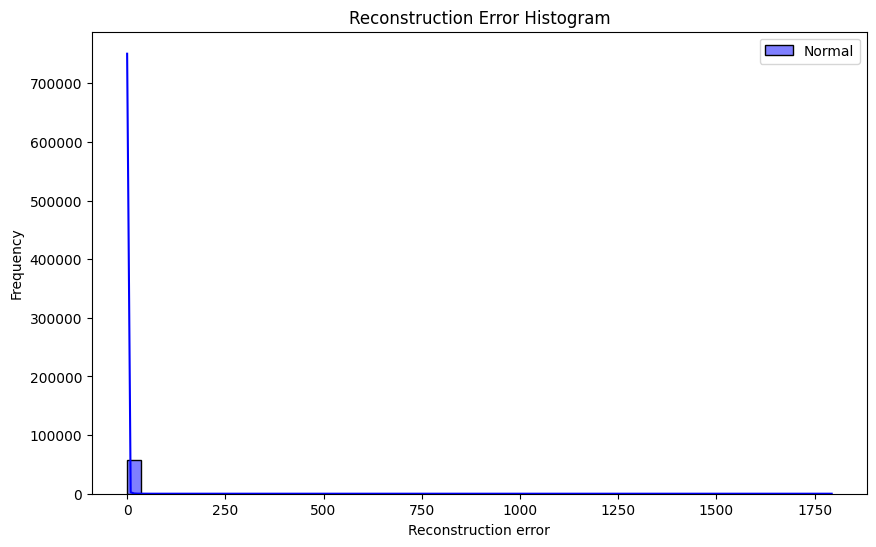

In [66]:
import seaborn as sns

# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=50, kde=True, color='blue', label='Normal')
#sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
#plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()

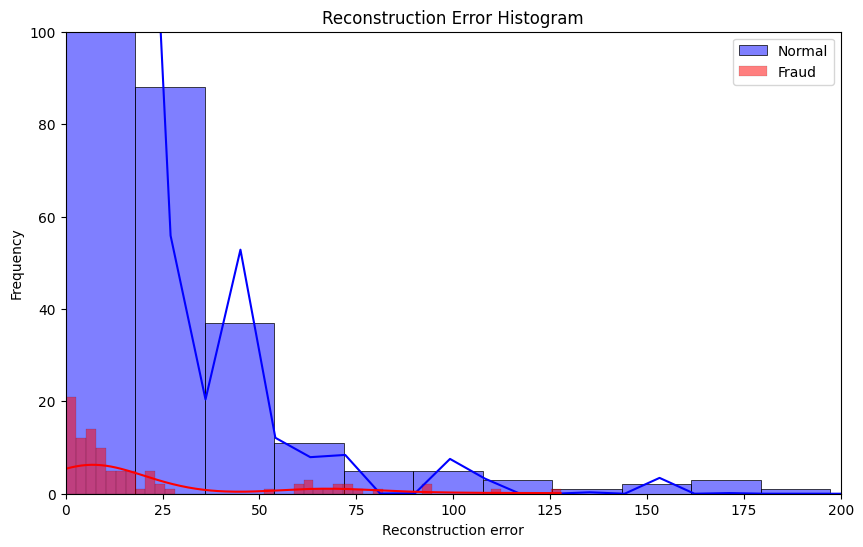

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
upper_limit=200
upper_y_limit=100
# Assuming reconstruction_errors and y_valid are defined
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=100, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Option 1: Limit the x-axis range to zoom in on a specific area
plt.xlim(0, upper_limit)  # Set 'upper_limit' to a value that suits your data
# Set the y-axis limits
plt.ylim(0, upper_y_limit)  # Set 'lower_y_limit' and 'upper_y_limit' to values that suit your data

# Option 2: Use a log scale for the x-axis
# plt.xscale('log')

# Add a line for the chosen threshold =
# chosen_threshold = your_threshold_value
# plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Architecture 3: Denoising (using gaussian noise)

In [ ]:
# Reconstruct the validation data (normal and fraudulent combined)
X_valid_reconstructed = autoencoder_3.predict(X_valid)

# Calculate the mean squared error (reconstruction error) for each transaction
reconstruction_errors = np.mean(np.power(X_valid - X_valid_reconstructed, 2), axis=1)
#axis=1, the function computes the mean across each row (i.e., across all features of a single transaction)
#resulting in a single error value for each transaction.a
# It quantifies, on average, how much the model's reconstruction of a transaction
# deviates from the original transaction data.

1781/1781 [==============================] - 4s 2ms/step


In [ ]:
reconstruction_errors.shape

(56962,)

In [ ]:
reconstruction_errors[:10]

array([0.7477448 , 0.55272783, 0.11741525, 0.8974301 , 0.15252512,
       0.57281404, 0.54417065, 0.70583247, 0.14975065, 0.43985504])

In [ ]:
print(max(reconstruction_errors))
print(min(reconstruction_errors))

1798.4392551655096
0.03472119851259395


In [ ]:
X_valid.shape

(56962, 30)

In [ ]:
# Using statistical method:
# Setting a threshold as be the mean error plus three standard deviations.
threshold = np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors)

In [ ]:
threshold

17.40861836768697

In [ ]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [ ]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 197
Number of normal transactions detected: 56765


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.14      0.27      0.18        99

    accuracy                           1.00     56962
   macro avg       0.57      0.63      0.59     56962
weighted avg       1.00      1.00      1.00     56962

[[56693   170]
 [   72    27]]


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# The reconstruction errors can serve as the anomaly scores (higher error = more anomalous)
anomaly_scores = reconstruction_errors

# Calculate AUC
roc_auc = roc_auc_score(y_valid, anomaly_scores)
print(f"AUC: {roc_auc}") # provides an overall measure of model performance,

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid, anomaly_scores)
# Calculate AUPRC
auprc = auc(recall, precision)
print(f"AUPRC: {auprc}") #gives an indication of how well the model identifies the positive (fraudulent) class.


AUC: 0.9414390817412114
AUPRC: 0.10871327399188577


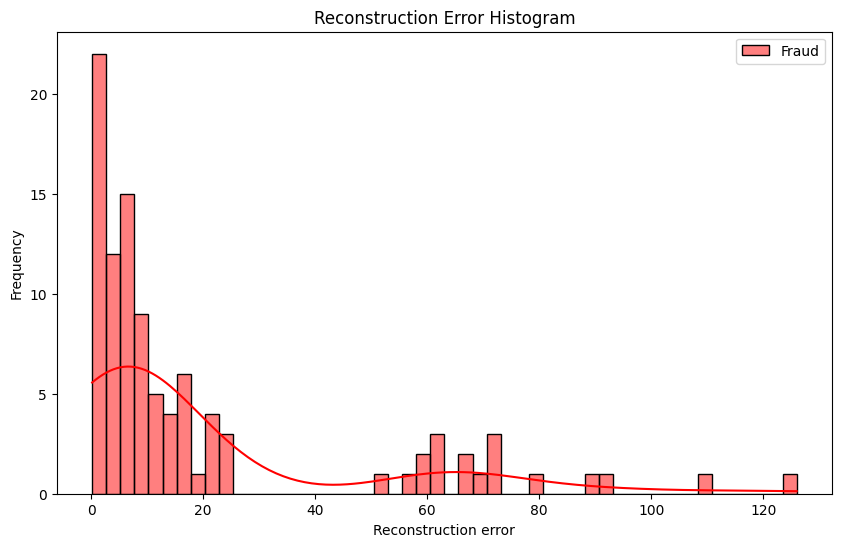

In [ ]:
import seaborn as sns

# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
#sns.histplot(errors_normal, bins=50, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
#plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()


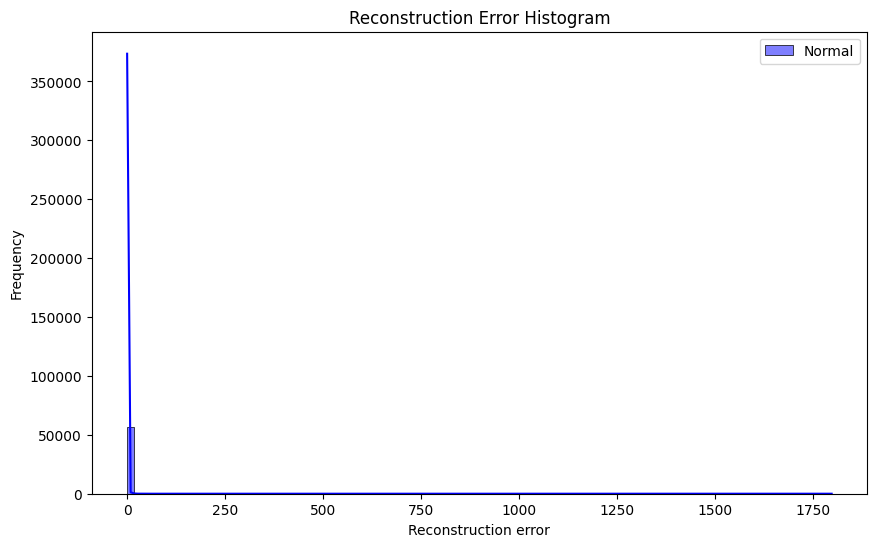

In [ ]:
import seaborn as sns

# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=100, kde=True, color='blue', label='Normal')
#sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
#plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()

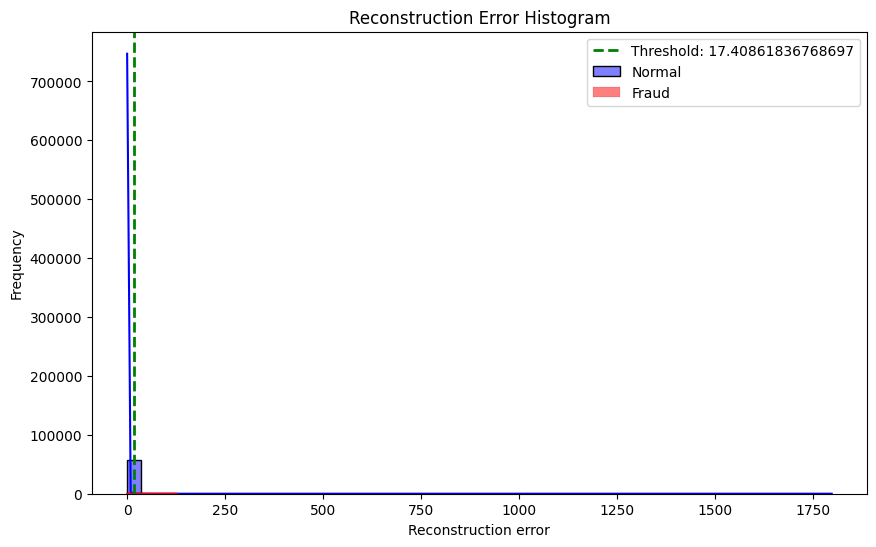

In [ ]:
import seaborn as sns
chosen_threshold=17.40861836768697
# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=50, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()

### Architecture -3: Threshold 2

In [ ]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
threshold=2
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [ ]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 2233
Number of normal transactions detected: 54729


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.83      0.07        99

    accuracy                           0.96     56962
   macro avg       0.52      0.90      0.53     56962
weighted avg       1.00      0.96      0.98     56962

[[54712  2151]
 [   17    82]]


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# The reconstruction errors can serve as the anomaly scores (higher error = more anomalous)
anomaly_scores = reconstruction_errors

# Calculate AUC
roc_auc = roc_auc_score(y_valid, anomaly_scores)
print(f"AUC: {roc_auc}") # provides an overall measure of model performance,

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid, anomaly_scores)
# Calculate AUPRC
auprc = auc(recall, precision)
print(f"AUPRC: {auprc}") #gives an indication of how well the model identifies the positive (fraudulent) class.


AUC: 0.9414390817412114
AUPRC: 0.10871327399188577


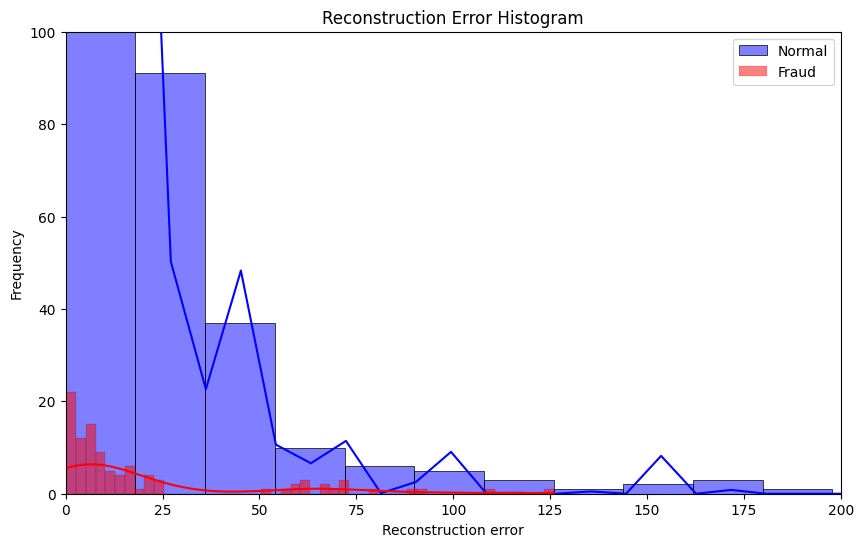

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
upper_limit=200
upper_y_limit=100
# Assuming reconstruction_errors and y_valid are defined
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=100, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Option 1: Limit the x-axis range to zoom in on a specific area
plt.xlim(0, upper_limit)  # Set 'upper_limit' to a value that suits your data
# Set the y-axis limits
plt.ylim(0, upper_y_limit)  # Set 'lower_y_limit' and 'upper_y_limit' to values that suit your data

# Option 2: Use a log scale for the x-axis
# plt.xscale('log')

# Add a line for the chosen threshold =
# chosen_threshold = your_threshold_value
# plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Architecture 4: Denoising without dropout

In [80]:
# Reconstruct the validation data (normal and fraudulent combined)
X_valid_reconstructed = autoencoder_4.predict(X_valid)

# Calculate the mean squared error (reconstruction error) for each transaction
reconstruction_errors = np.mean(np.power(X_valid - X_valid_reconstructed, 2), axis=1)
#axis=1, the function computes the mean across each row (i.e., across all features of a single transaction)
#resulting in a single error value for each transaction.a
# It quantifies, on average, how much the model's reconstruction of a transaction
# deviates from the original transaction data.

1781/1781 [==============================] - 4s 2ms/step


In [81]:
reconstruction_errors.shape

(56962,)

In [83]:
print(max(reconstruction_errors))
print(min(reconstruction_errors))

69.01445396502432
0.008155649006616823


In [84]:
X_valid.shape

(56962, 30)

In [85]:
# Using statistical method:
# Setting a threshold as be the mean error plus three standard deviations.
threshold = np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors)

In [86]:
threshold

1.9133650959219395

In [87]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [88]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 465
Number of normal transactions detected: 56497


In [89]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.12      0.59      0.21        99

    accuracy                           0.99     56962
   macro avg       0.56      0.79      0.60     56962
weighted avg       1.00      0.99      0.99     56962

[[56456   407]
 [   41    58]]


In [90]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# The reconstruction errors can serve as the anomaly scores (higher error = more anomalous)
anomaly_scores = reconstruction_errors

# Calculate AUC
roc_auc = roc_auc_score(y_valid, anomaly_scores)
print(f"AUC: {roc_auc}") # provides an overall measure of model performance,

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid, anomaly_scores)
# Calculate AUPRC
auprc = auc(recall, precision)
print(f"AUPRC: {auprc}") #gives an indication of how well the model identifies the positive (fraudulent) class.


AUC: 0.9536459862682538
AUPRC: 0.13145673528734667


In [107]:
#Trying another threshold
threshold=3
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [108]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 228
Number of normal transactions detected: 56734


In [109]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.17      0.39      0.24        99

    accuracy                           1.00     56962
   macro avg       0.58      0.70      0.62     56962
weighted avg       1.00      1.00      1.00     56962

[[56674   189]
 [   60    39]]


In [110]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# The reconstruction errors can serve as the anomaly scores (higher error = more anomalous)
anomaly_scores = reconstruction_errors

# Calculate AUC
roc_auc = roc_auc_score(y_valid, anomaly_scores)
print(f"AUC: {roc_auc}") # provides an overall measure of model performance,

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid, anomaly_scores)
# Calculate AUPRC
auprc = auc(recall, precision)
print(f"AUPRC: {auprc}") #gives an indication of how well the model identifies the positive (fraudulent) class.


AUC: 0.9536459862682538
AUPRC: 0.13145673528734667


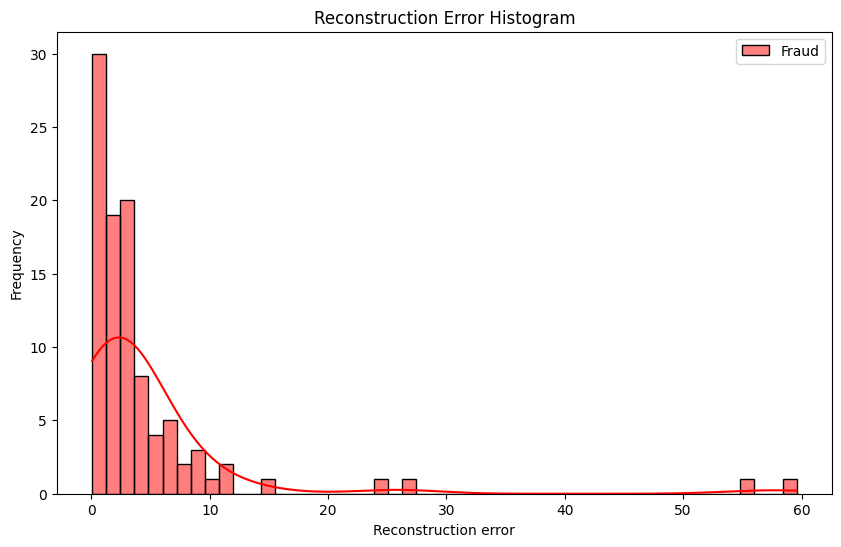

In [91]:
import seaborn as sns

# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
#sns.histplot(errors_normal, bins=50, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
#plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()


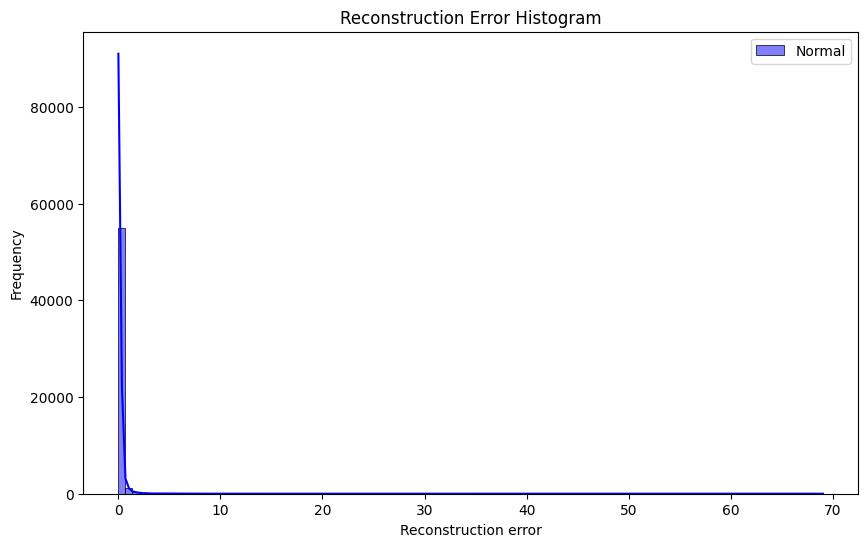

In [92]:
import seaborn as sns

# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=100, kde=True, color='blue', label='Normal')
#sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
#plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()

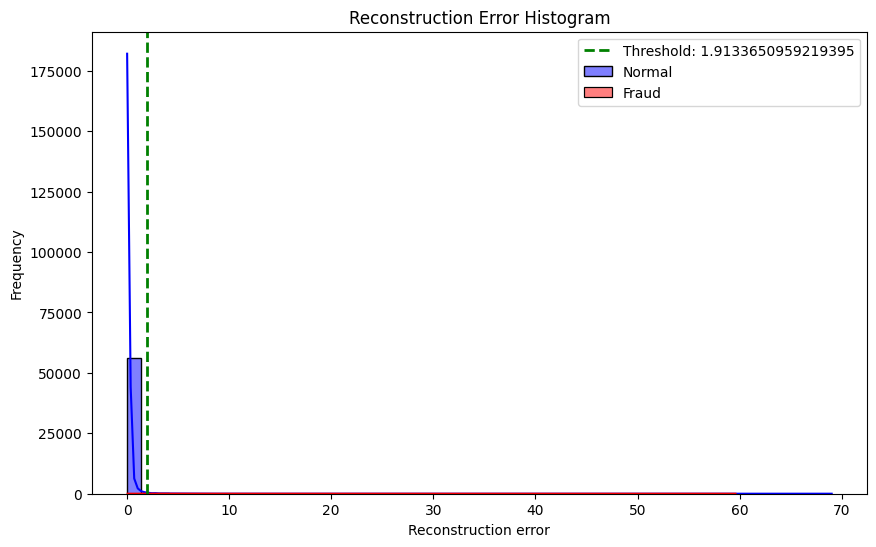

In [94]:
import seaborn as sns
chosen_threshold=1.9133650959219395
# Normal and fraudulent transactions are separated in the validation set
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=50, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Add a line for the chosen threshold
plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()

plt.show()

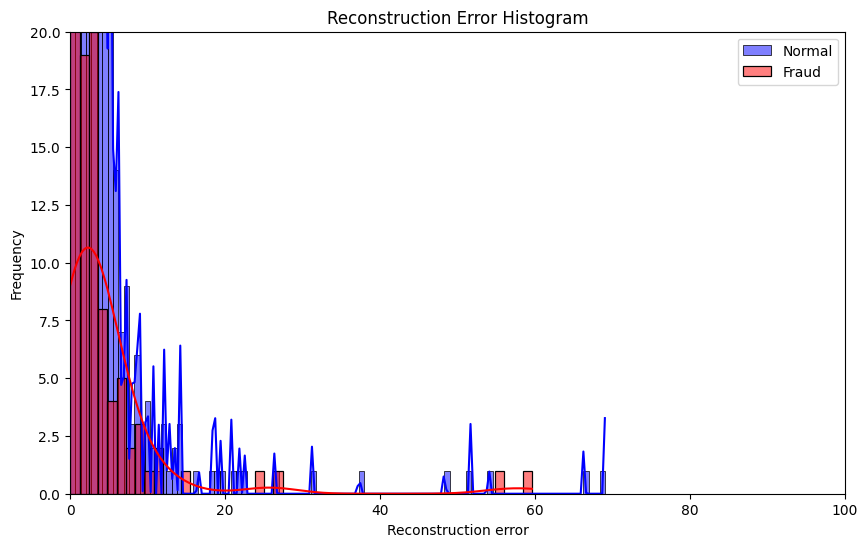

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
upper_limit=100
upper_y_limit=20
# Assuming reconstruction_errors and y_valid are defined
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=100, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Option 1: Limit the x-axis range to zoom in on a specific area
plt.xlim(0, upper_limit)  # Set 'upper_limit' to a value that suits your data
# Set the y-axis limits
plt.ylim(0, upper_y_limit)  # Set 'lower_y_limit' and 'upper_y_limit' to values that suit your data

# Option 2: Use a log scale for the x-axis
# plt.xscale('log')

# Add a line for the chosen threshold =
# chosen_threshold = your_threshold_value
# plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


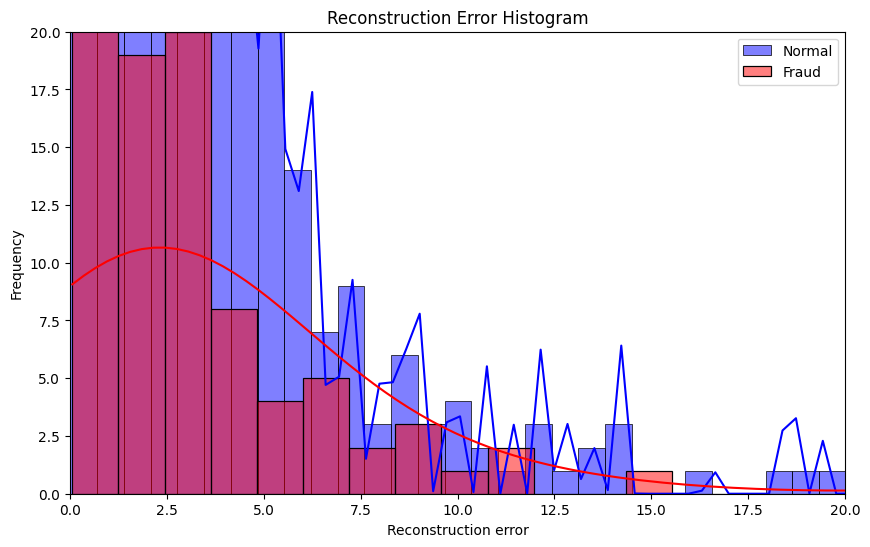

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
upper_limit=20
upper_y_limit=20
# Assuming reconstruction_errors and y_valid are defined
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=100, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Option 1: Limit the x-axis range to zoom in on a specific area
plt.xlim(0, upper_limit)  # Set 'upper_limit' to a value that suits your data
# Set the y-axis limits
plt.ylim(0, upper_y_limit)  # Set 'lower_y_limit' and 'upper_y_limit' to values that suit your data

# Option 2: Use a log scale for the x-axis
# plt.xscale('log')

# Add a line for the chosen threshold =
# chosen_threshold = your_threshold_value
# plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Architecture 5

In [123]:
# Reconstruct the validation data (normal and fraudulent combined)
X_valid_reconstructed = autoencoder_5.predict(X_valid)

# Calculate the mean squared error (reconstruction error) for each transaction
reconstruction_errors = np.mean(np.power(X_valid - X_valid_reconstructed, 2), axis=1)
#axis=1, the function computes the mean across each row (i.e., across all features of a single transaction)
#resulting in a single error value for each transaction.a
# It quantifies, on average, how much the model's reconstruction of a transaction
# deviates from the original transaction data.

1781/1781 [==============================] - 8s 4ms/step


In [124]:
reconstruction_errors.shape

(56962,)

In [125]:
print(max(reconstruction_errors))
print(min(reconstruction_errors))

295.5828070945571
0.06464503254195093


In [126]:
X_valid.shape

(56962, 30)

In [127]:
# Using statistical method:
# Setting a threshold as be the mean error plus three standard deviations.
threshold = np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors)

In [128]:
threshold

5.408468575785764

In [129]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [130]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 408
Number of normal transactions detected: 56554


In [131]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.15      0.63      0.24        99

    accuracy                           0.99     56962
   macro avg       0.58      0.81      0.62     56962
weighted avg       1.00      0.99      1.00     56962

[[56517   346]
 [   37    62]]


In [132]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# The reconstruction errors can serve as the anomaly scores (higher error = more anomalous)
anomaly_scores = reconstruction_errors

# Calculate AUC
roc_auc = roc_auc_score(y_valid, anomaly_scores)
print(f"AUC: {roc_auc}") # provides an overall measure of model performance,

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid, anomaly_scores)
# Calculate AUPRC
auprc = auc(recall, precision)
print(f"AUPRC: {auprc}") #gives an indication of how well the model identifies the positive (fraudulent) class.


AUC: 0.950648528440766
AUPRC: 0.23304568292651348


In [133]:
# Using statistical method:
# Setting a threshold as be the mean error plus three standard deviations.
threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)

In [134]:
threshold

7.771234809250025

In [135]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [136]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 252
Number of normal transactions detected: 56710


In [137]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.19      0.49      0.28        99

    accuracy                           1.00     56962
   macro avg       0.60      0.75      0.64     56962
weighted avg       1.00      1.00      1.00     56962

[[56660   203]
 [   50    49]]


In [143]:
threshold=12

In [144]:
# Classifying each transaction in the validation set
# Classifying as anomalous (1) if reconstruction error exceeds the threshold, otherwise normal (0)
predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

In [145]:
# Count the number of anomalies (1s) and normals (0s) in the predictions
num_anomalies_detected = predictions.count(1)
num_normals_detected = predictions.count(0)

print("Number of anomalies detected:", num_anomalies_detected)
print("Number of normal transactions detected:", num_normals_detected)

Number of anomalies detected: 133
Number of normal transactions detected: 56829


In [146]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_valid contains the actual labels for the validation set
print(classification_report(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.28      0.37      0.32        99

    accuracy                           1.00     56962
   macro avg       0.64      0.69      0.66     56962
weighted avg       1.00      1.00      1.00     56962

[[56767    96]
 [   62    37]]


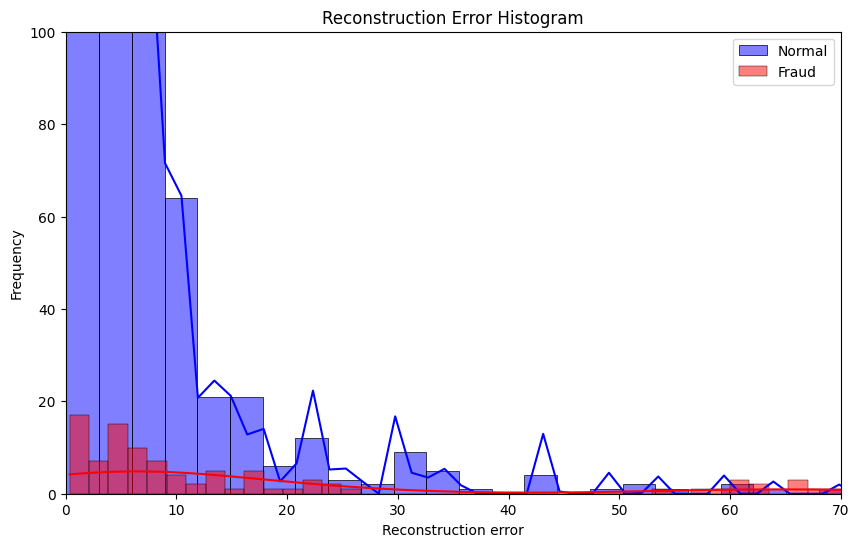

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
upper_limit=70
upper_y_limit=100
# Assuming reconstruction_errors and y_valid are defined
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=100, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Option 1: Limit the x-axis range to zoom in on a specific area
plt.xlim(0, upper_limit)  # Set 'upper_limit' to a value that suits your data
# Set the y-axis limits
plt.ylim(0, upper_y_limit)  # Set 'lower_y_limit' and 'upper_y_limit' to values that suit your data

# Option 2: Use a log scale for the x-axis
# plt.xscale('log')

# Add a line for the chosen threshold =
# chosen_threshold = your_threshold_value
# plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


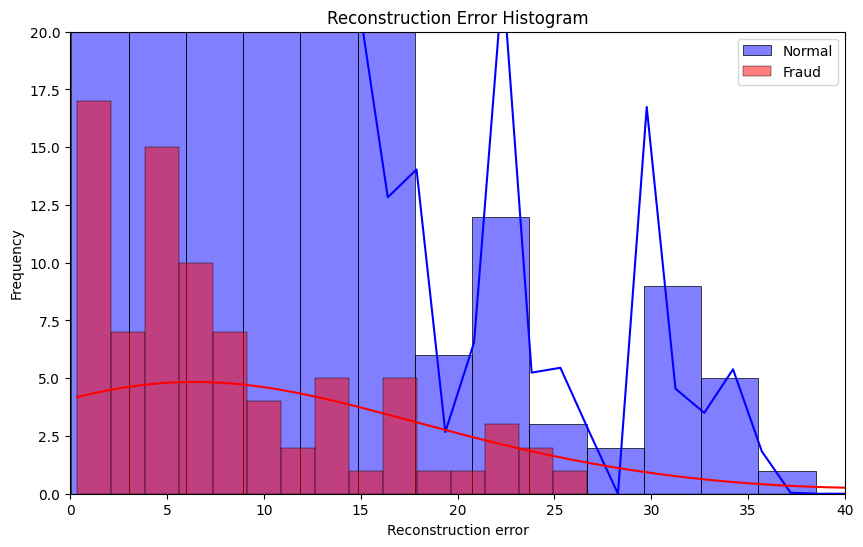

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
upper_limit=40
upper_y_limit=20
# Assuming reconstruction_errors and y_valid are defined
errors_normal = reconstruction_errors[y_valid == 0]
errors_fraud = reconstruction_errors[y_valid == 1]

# Create a histogram of the reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=100, kde=True, color='blue', label='Normal')
sns.histplot(errors_fraud, bins=50, kde=True, color='red', label='Fraud')

# Option 1: Limit the x-axis range to zoom in on a specific area
plt.xlim(0, upper_limit)  # Set 'upper_limit' to a value that suits your data
# Set the y-axis limits
plt.ylim(0, upper_y_limit)  # Set 'lower_y_limit' and 'upper_y_limit' to values that suit your data

# Option 2: Use a log scale for the x-axis
# plt.xscale('log')

# Add a line for the chosen threshold =
# chosen_threshold = your_threshold_value
# plt.axvline(chosen_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {chosen_threshold}')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Part 5: Evaluation
   - Evaluate your model on a test set containing both normal and fraudulent transactions. Use metrics suitable for imbalanced classification problems, such as precision, recall, F1-score, and the area under the ROC curve (AUC).
   - Discuss the performance of your model and any challenges you encountered.

## Architecture 1 Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score

# Reconstruct the test set data
X_test_reconstructed = autoencoder.predict(X_test)
test_reconstruction_errors = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

threshold = 17.434276005380312

# Apply the threshold to classify transactions
test_predictions = [1 if e > threshold else 0 for e in test_reconstruction_errors]

# Calculate the metrics
print("Classification report:")
print(classification_report(y_test, test_predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

roc_auc_test = roc_auc_score(y_test, test_reconstruction_errors)
print(f"Test ROC AUC: {roc_auc_test}")

precision_test, recall_test, _ = precision_recall_curve(y_test, test_reconstruction_errors)
auprc_test = auc(recall_test, precision_test)
print(f"Test AUPRC: {auprc_test}")

f1_test = f1_score(y_test, test_predictions)
print(f"Test F1 Score: {f1_test}")


1781/1781 [==============================] - 4s 2ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.17      0.34      0.23        98

    accuracy                           1.00     56962
   macro avg       0.59      0.67      0.61     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56705   159]
 [   65    33]]
Test ROC AUC: 0.9512811807334075
Test AUPRC: 0.15736676352942416
Test F1 Score: 0.22758620689655168


Precision and Recall for Normal Transactions (Class 0):
Precision is excellent at 1.00, which means nearly all transactions the model predicted as normal were actually normal.
Recall is also outstanding at nearly 1.00, indicating the model successfully identified almost all normal transactions.

Precision and Recall for Fraudulent Transactions (Class 1):
Precision of 0.17 suggests that only 17% of transactions the model flagged as fraudulent were actually fraudulent.
Recall of 0.34 indicates the model identified 34% of all actual fraudulent transactions, which is not ideal but does show that the model has some capability to detect fraud.
F1 Score for Fraudulent Transactions:

An F1 Score of around 0.23 for fraudulent transactions suggests that the balance between precision and recall could be improved. The F1 score is particularly low for the fraudulent class, indicating that the model is not as effective in detecting fraudulent transactions as it is with normal ones.

Accuracy:
The overall accuracy of the model is high at 1.00, but this metric is less informative due to the severe class imbalance in the dataset.

Confusion Matrix:
The model correctly identified 56,705 out of 56,864 normal transactions but falsely flagged 159 as fraudulent (false positives).
Out of 98 fraudulent transactions, it correctly detected 33 but missed 65 (false negatives).

ROC AUC and AUPRC:
A ROC AUC of 0.951 is quite high and suggests good separability between classes.
The AUPRC of 0.157, while not as high as ROC AUC, is more relevant for imbalanced datasets and indicates the model's performance in recovering fraudulent transactions.

The main challenge seems to be the imbalanced dataset. Further experimentation can reveal whether this is an architecture problem or the dataset is the main cause for the lower scores.

## Architecture 2 Evaluation

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score

# Reconstruct the test set data
X_test_reconstructed = autoencoder_2.predict(X_test)
test_reconstruction_errors = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

threshold = 17.36977293936394

# Apply the threshold to classify transactions
test_predictions = [1 if e > threshold else 0 for e in test_reconstruction_errors]

# Calculate the metrics
print("Classification report:")
print(classification_report(y_test, test_predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

roc_auc_test = roc_auc_score(y_test, test_reconstruction_errors)
print(f"Test ROC AUC: {roc_auc_test}")

precision_test, recall_test, _ = precision_recall_curve(y_test, test_reconstruction_errors)
auprc_test = auc(recall_test, precision_test)
print(f"Test AUPRC: {auprc_test}")

f1_test = f1_score(y_test, test_predictions)
print(f"Test F1 Score: {f1_test}")


1781/1781 [==============================] - 4s 2ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.18      0.36      0.24        98

    accuracy                           1.00     56962
   macro avg       0.59      0.68      0.62     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56704   160]
 [   63    35]]
Test ROC AUC: 0.9532233370275515
Test AUPRC: 0.16524355537215568
Test F1 Score: 0.23890784982935157


Metrics improved very slighly. Need to experiment with more varying autoencoders.

## Architecture 3 Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score

# Reconstruct the test set data
X_test_reconstructed = autoencoder_3.predict(X_test)
test_reconstruction_errors = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

threshold = 17.40861836768697

# Apply the threshold to classify transactions
test_predictions = [1 if e > threshold else 0 for e in test_reconstruction_errors]

# Calculate the metrics
print("Classification report:")
print(classification_report(y_test, test_predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

roc_auc_test = roc_auc_score(y_test, test_reconstruction_errors)
print(f"Test ROC AUC: {roc_auc_test}")

precision_test, recall_test, _ = precision_recall_curve(y_test, test_reconstruction_errors)
auprc_test = auc(recall_test, precision_test)
print(f"Test AUPRC: {auprc_test}")

f1_test = f1_score(y_test, test_predictions)
print(f"Test F1 Score: {f1_test}")


1781/1781 [==============================] - 3s 2ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.17      0.34      0.23        98

    accuracy                           1.00     56962
   macro avg       0.59      0.67      0.61     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56705   159]
 [   65    33]]
Test ROC AUC: 0.9505318095161531
Test AUPRC: 0.1559072144799027
Test F1 Score: 0.22758620689655168


Again, each of the metrics are quite similar to that of model 1, and it seems that changing the architecture of the autoencoder is having little effect.

## Architecture 4 Evaluation

In [112]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score

# Reconstruct the test set data
X_test_reconstructed = autoencoder_4.predict(X_test)
test_reconstruction_errors = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

threshold = 1.9133650959219395

# Apply the threshold to classify transactions
test_predictions = [1 if e > threshold else 0 for e in test_reconstruction_errors]

# Calculate the metrics
print("Classification report:")
print(classification_report(y_test, test_predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

roc_auc_test = roc_auc_score(y_test, test_reconstruction_errors)
print(f"Test ROC AUC: {roc_auc_test}")

precision_test, recall_test, _ = precision_recall_curve(y_test, test_reconstruction_errors)
auprc_test = auc(recall_test, precision_test)
print(f"Test AUPRC: {auprc_test}")

f1_test = f1_score(y_test, test_predictions)
print(f"Test F1 Score: {f1_test}")


1781/1781 [==============================] - 5s 3ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.68      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.84      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix:
[[56435   429]
 [   31    67]]
Test ROC AUC: 0.9575201985690168
Test AUPRC: 0.20132414197803483
Test F1 Score: 0.2255892255892256


Performance Analysis:

Accuracy: The model achieves a high overall accuracy of approximately 99%, indicating that it correctly classifies the majority of instances.

Precision and Recall: Precision for the minority class (class 1) is quite low at 14%, indicating that a large portion of the instances classified as positive are actually false positives. However, recall for the minority class is relatively high at 68%, indicating that the model captures a significant portion of the actual positive instances.

F1-Score: The F1-score for the minority class is low at 0.23, indicating that the model struggles to achieve a balance between precision and recall for this class.

ROC AUC: The ROC AUC (Receiver Operating Characteristic Area Under Curve) is high, indicating good overall performance in terms separation of classes.

AUPRC (Area Under Precision-Recall Curve) scores is not as good.

Confusion Matrix: Looking at the confusion matrix, it's evident that there are a significant number of false positives (429) compared to true positives (67) for the minority class.

Challenges Encountered:

Class Imbalance: The dataset appears to suffer from class imbalance, with a large number of instances belonging to the majority class (class 0) and only a small number belonging to the minority class (class 1).

## Architecture 5 Evaluation

In [147]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score

# Reconstruct the test set data
X_test_reconstructed = autoencoder_5.predict(X_test)
test_reconstruction_errors = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

threshold = 12

# Apply the threshold to classify transactions
test_predictions = [1 if e > threshold else 0 for e in test_reconstruction_errors]

# Calculate the metrics
print("Classification report:")
print(classification_report(y_test, test_predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

roc_auc_test = roc_auc_score(y_test, test_reconstruction_errors)
print(f"Test ROC AUC: {roc_auc_test}")

precision_test, recall_test, _ = precision_recall_curve(y_test, test_reconstruction_errors)
auprc_test = auc(recall_test, precision_test)
print(f"Test AUPRC: {auprc_test}")

f1_test = f1_score(y_test, test_predictions)
print(f"Test F1 Score: {f1_test}")


1781/1781 [==============================] - 5s 3ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.32      0.45      0.37        98

    accuracy                           1.00     56962
   macro avg       0.66      0.72      0.68     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56769    95]
 [   54    44]]
Test ROC AUC: 0.9603412869086857
Test AUPRC: 0.3378209940612407
Test F1 Score: 0.3713080168776371


Accuracy: The model achieves a very high overall accuracy of approximately 100%, indicating that it correctly classifies the majority of instances.

Precision and Recall: Precision for the minority class (class 1) has improved to 32%, indicating that a larger portion of the instances classified as positive are true positives. However, recall for the minority class remains relatively low at 45%, indicating that the model still misses a significant portion of the actual positive instances.

False positive and False Negative: For false positives, the model has predicted 95 normal transactions (Class 0) as fraudulent. The model has 54 false negatives, which means it failed to identify 54 fraudulent transactions.

F1-Score: The F1-score for the minority class has improved to 0.37, indicating a better balance between precision and recall compared to the previous model.

ROC AUC and AUPRC: Both the ROC AUC (Receiver Operating Characteristic Area Under Curve) and AUPRC (Area Under Precision-Recall Curve) scores have increased compared to architecture 4, indicating improved overall performance in terms of ranking and separation of classes.

Confusion Matrix: Compared to the results of the best architecture so far (architecture 4), the confusion matrix shows a reduction in false positives (from 429 to 95) and an increase in true positives (from 67 to 44) for the minority class, reflecting the improvement in precision.

Challenges of class imbalance, tradeoff between precision and recall, and choosing the right threshold remains.

## Overall Evaluation

Overall, it seems utilizing denoising using dropout has the best effect in improving the overall performance of the models. While architecture 4 achieved the lowest validation loss, architecture 5 achieved the best final results, which may correspond to better tuning of it's hyperparameters.

Repeating some the performance results of architecture 5, it achieved high overall accuracy of approximately 100%, with the highest precision and recall of the minority class, at 0.32 and 0.45, respectively. It also achieved the best F1 score among the other models, of 0.338.

The (highest) ROC AUC score of 0.9603 indicates that the model is very effective at distinguishing between the positive and negative classes across various threshold values.

AUPRC is particularly useful for evaluating models trained on imbalanced datasets like ours, as it provides insight into the model's performance on the minority class (class 1).
AUPRC score of 0.3378 indicates that the model achieves moderate performance in terms of precision and recall for the minority class, but the best amongst the others.

In summary, the model exhibits strong overall performance.  The AUPRC score, while moderate, suggests reasonable performance in terms of precision and recall, especially considering the class imbalance in the dataset.

Summary of Challenges Encountered across all models:

Class Imbalance: Although the model performance has improved for the last architecture, the dataset still suffers from class imbalance, with a large number of instances belonging to the majority class (class 0) and only a small number belonging to the minority class (class 1). This class imbalance poses challenges in effectively capturing and classifying minority class instances, no matter the architecture employed.

Trade-off Between Precision and Recall, False Positives and False Negatives: Achieving high precision often comes at the cost of lower recall and vice versa. In the 5th architecture, improving precision for the minority class has led to a decrease in recall, indicating that the model may still struggle to capture all instances of the minority class. Same can be said for acheiving a balance between False Positives and False Negatives. Although, the cost of a false positive might be significantly different from the cost of a false negative in fraud detection. A false negative (a missed fraudulent transaction) could be much more costly than a false positive (a legitimate transaction flagged as fraudulent). Therefore, depending on the cost associated with false positives (such as customer inconvenience or operational workload) and false negatives (potential for financial loss), the model can be fine-tuned.

Threshold Selection: The choice of threshold for classification has a significant impact on model performance. In the best architecture (model 5), a threshold of 12 has been chosen, which may still not be optimal. Fine-tuning the threshold could potentially improve the model's performance further as has been observed from our experimentation with the 5 models.

In summary, while changing the architecture, we managed to find a model that demonstrates strong and improved overall performance, there are still challenges posed by class imbalance and the trade-off between precision and recall or false positive and false negative. Further refinement and experimentation with threshold selection and potentially incorporating additional techniques to address class imbalance could lead to further improvements in model performance.